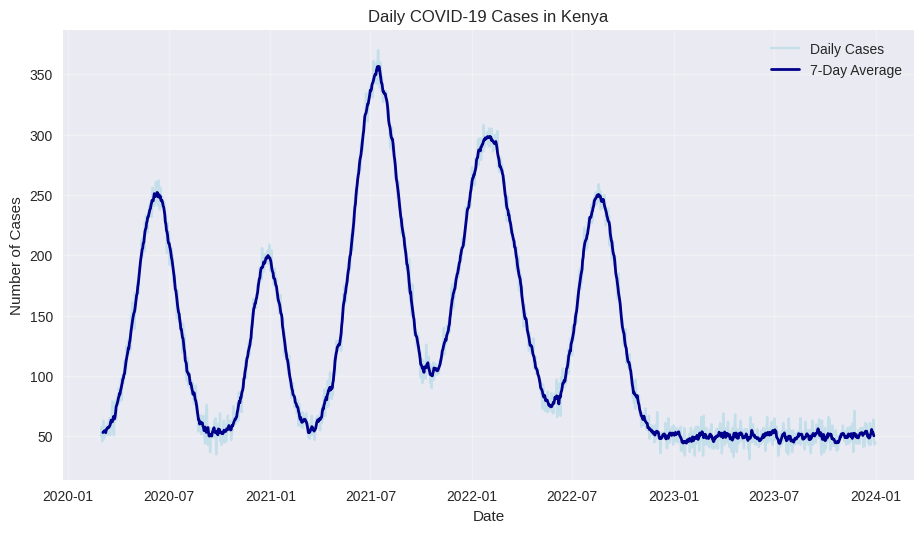

In [4]:
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

class KenyaCovidAnalyzerGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Kenya COVID-19 Data Analyzer")
        self.root.geometry("1200x800")
        self.data = None
        self.counties = [
            'Nairobi', 'Mombasa', 'Kisumu', 'Nakuru', 'Eldoret',
            'Machakos', 'Meru', 'Thika', 'Malindi', 'Kitale'
        ]
        
        # Create main container
        self.main_frame = ttk.Frame(root)
        self.main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Create control panel
        self.create_control_panel()
        
        # Create visualization area
        self.create_visualization_area()
        
        # Status bar
        self.status_var = tk.StringVar()
        self.status_bar = ttk.Label(root, textvariable=self.status_var, relief=tk.SUNKEN)
        self.status_bar.pack(fill=tk.X)
        self.update_status("Ready")
        
        # Initialize with sample data
        self.fetch_data()
    
    def update_status(self, message):
        self.status_var.set(message)
        self.root.update_idletasks()
    
    def create_control_panel(self):
        control_frame = ttk.LabelFrame(self.main_frame, text="Controls", padding=(10, 5))
        control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=5, pady=5)
        
        # Data buttons
        ttk.Button(control_frame, text="Load Sample Data", command=self.fetch_data).pack(fill=tk.X, pady=5)
        ttk.Button(control_frame, text="Load CSV File", command=self.load_csv).pack(fill=tk.X, pady=5)
        ttk.Button(control_frame, text="Save Report", command=self.generate_report).pack(fill=tk.X, pady=5)
        
        # Analysis options
        ttk.Separator(control_frame, orient=tk.HORIZONTAL).pack(fill=tk.X, pady=10)
        
        analysis_frame = ttk.LabelFrame(control_frame, text="Analysis Options", padding=(10, 5))
        analysis_frame.pack(fill=tk.X, pady=5)
        
        self.analysis_var = tk.StringVar(value="overview")
        ttk.Radiobutton(analysis_frame, text="Overview", variable=self.analysis_var, 
                       value="overview", command=self.update_visualizations).pack(anchor=tk.W)
        ttk.Radiobutton(analysis_frame, text="County Comparison", variable=self.analysis_var, 
                       value="county", command=self.update_visualizations).pack(anchor=tk.W)
        ttk.Radiobutton(analysis_frame, text="Time Patterns", variable=self.analysis_var, 
                       value="time", command=self.update_visualizations).pack(anchor=tk.W)
        
        # County selection
        ttk.Separator(control_frame, orient=tk.HORIZONTAL).pack(fill=tk.X, pady=10)
        
        county_frame = ttk.LabelFrame(control_frame, text="County Selection", padding=(10, 5))
        county_frame.pack(fill=tk.X, pady=5)
        
        self.county_vars = []
        for county in self.counties:
            var = tk.IntVar(value=1)
            cb = ttk.Checkbutton(county_frame, text=county, variable=var)
            cb.pack(anchor=tk.W)
            self.county_vars.append((county, var))
    
    def create_visualization_area(self):
        viz_frame = ttk.Frame(self.main_frame)
        viz_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=5, pady=5)
        
        # Create matplotlib figure
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15)
        
        # Create canvas for matplotlib figure
        self.canvas = FigureCanvasTkAgg(self.fig, master=viz_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Text output area
        self.text_output = tk.Text(viz_frame, height=10, wrap=tk.WORD)
        self.text_output.pack(fill=tk.X, pady=(5, 0))
        
        # Add scrollbar to text output
        scrollbar = ttk.Scrollbar(viz_frame, orient=tk.VERTICAL, command=self.text_output.yview)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        self.text_output.config(yscrollcommand=scrollbar.set)
    
    def fetch_data(self):
        """Generate sample COVID-19 data"""
        try:
            self.update_status("Generating sample data...")
            
            dates = pd.date_range(start='2020-03-01', end='2024-01-01', freq='D')
            
            np.random.seed(42)
            base_cases = np.random.poisson(50, len(dates))
            
            wave1 = np.exp(-((np.arange(len(dates)) - 100) / 50) ** 2) * 200
            wave2 = np.exp(-((np.arange(len(dates)) - 300) / 40) ** 2) * 150
            wave3 = np.exp(-((np.arange(len(dates)) - 500) / 60) ** 2) * 300
            wave4 = np.exp(-((np.arange(len(dates)) - 700) / 70) ** 2) * 250
            wave5 = np.exp(-((np.arange(len(dates)) - 900) / 50) ** 2) * 200
            
            daily_cases = base_cases + wave1 + wave2 + wave3 + wave4 + wave5
            daily_cases = np.maximum(daily_cases, 0).astype(int)
            
            county_data = {}
            for county in self.counties:
                county_factor = np.random.uniform(0.2, 1.5)
                county_data[county] = (daily_cases * county_factor).astype(int)
            
            self.data = pd.DataFrame({
                'date': dates,
                'daily_cases': daily_cases,
                'cumulative_cases': daily_cases.cumsum(),
                **county_data
            })
            
            self.data['cases_7day_avg'] = self.data['daily_cases'].rolling(window=7, center=True).mean()
            
            self.update_status(f"Sample data loaded: {len(self.data)} records from {dates[0].date()} to {dates[-1].date()}")
            self.update_visualizations()
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to generate sample data: {str(e)}")
            self.update_status("Error generating data")
    
    def load_csv(self):
        """Load data from CSV file"""
        try:
            file_path = filedialog.askopenfilename(
                title="Select COVID-19 Data CSV",
                filetypes=[("CSV files", "*.csv"), ("All files", "*.*")]
            )
            
            if not file_path:
                return
                
            self.update_status(f"Loading data from {file_path}...")
            self.data = pd.read_csv(file_path, parse_dates=['date'])
            
            # Ensure required columns exist
            required_cols = ['date', 'daily_cases']
            missing_cols = [col for col in required_cols if col not in self.data.columns]
            if missing_cols:
                raise ValueError(f"Missing required columns: {', '.join(missing_cols)}")
                
            # Calculate additional metrics if not present
            if 'cumulative_cases' not in self.data.columns:
                self.data['cumulative_cases'] = self.data['daily_cases'].cumsum()
                
            if 'cases_7day_avg' not in self.data.columns:
                self.data['cases_7day_avg'] = self.data['daily_cases'].rolling(window=7, center=True).mean()
                
            self.update_status(f"Data loaded: {len(self.data)} records from {self.data['date'].min().date()} to {self.data['date'].max().date()}")
            self.update_visualizations()
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load CSV file: {str(e)}")
            self.update_status("Error loading data")
    
    def analyze_trends(self):
        """Analyze COVID-19 trends"""
        if self.data is None:
            return None
            
        peak_date = self.data.loc[self.data['daily_cases'].idxmax(), 'date']
        peak_cases = self.data['daily_cases'].max()
        
        recent_data = self.data.tail(30)
        recent_trend = 'increasing' if recent_data['cases_7day_avg'].iloc[-1] > recent_data['cases_7day_avg'].iloc[0] else 'decreasing'
        
        county_totals = {county: self.data[county].sum() for county in self.counties if county in self.data.columns}
        top_county = max(county_totals.items(), key=lambda x: x[1]) if county_totals else ("None", 0)
        
        return {
            'total_cases': self.data['cumulative_cases'].iloc[-1],
            'peak_date': peak_date.strftime('%Y-%m-%d'),
            'peak_daily_cases': peak_cases,
            'recent_trend': recent_trend,
            'current_7day_avg': round(self.data['cases_7day_avg'].iloc[-1], 1),
            'top_county': top_county[0],
            'top_county_cases': top_county[1],
            'county_distribution': county_totals
        }
    
    def update_visualizations(self):
        """Update the visualizations based on current settings"""
        if self.data is None:
            return
            
        analysis_type = self.analysis_var.get()
        self.ax.clear()
        
        if analysis_type == "overview":
            self.show_overview()
        elif analysis_type == "county":
            self.show_county_comparison()
        elif analysis_type == "time":
            self.show_time_patterns()
            
        self.canvas.draw()
        self.show_analysis_summary()
    
    def show_overview(self):
        """Show overview visualizations"""
        self.ax.plot(self.data['date'], self.data['daily_cases'], alpha=0.6, color='lightblue', label='Daily Cases')
        self.ax.plot(self.data['date'], self.data['cases_7day_avg'], color='darkblue', linewidth=2, label='7-Day Average')
        self.ax.set_title('Daily COVID-19 Cases in Kenya')
        self.ax.set_xlabel('Date')
        self.ax.set_ylabel('Number of Cases')
        self.ax.legend()
        self.ax.grid(True, alpha=0.3)
    
    def show_county_comparison(self):
        """Show county comparison visualizations"""
        selected_counties = [county for county, var in self.county_vars if var.get() == 1]
        
        if not selected_counties:
            messagebox.showwarning("Warning", "No counties selected for comparison")
            return
            
        for county in selected_counties:
            if county in self.data.columns:
                county_avg = self.data[county].rolling(window=7).mean()
                self.ax.plot(self.data['date'], county_avg, label=county)
        
        self.ax.set_title('7-Day Average Comparison by County')
        self.ax.set_xlabel('Date')
        self.ax.set_ylabel('7-Day Average Cases')
        self.ax.legend()
        self.ax.grid(True, alpha=0.3)
    
    def show_time_patterns(self):
        """Show time pattern visualizations"""
        # Weekly pattern
        weekly_pattern = self.data.copy()
        weekly_pattern['weekday'] = weekly_pattern['date'].dt.day_name()
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        weekly_pattern = weekly_pattern.groupby('weekday')['daily_cases'].mean().reindex(weekday_order)
        
        self.ax.bar(weekly_pattern.index, weekly_pattern.values, color='purple', alpha=0.7)
        self.ax.set_title('Average Cases by Day of Week')
        self.ax.set_xlabel('Day of Week')
        self.ax.set_ylabel('Average Cases')
        self.ax.tick_params(axis='x', rotation=45)
    
    def show_analysis_summary(self):
        """Show analysis summary in text output"""
        analysis = self.analyze_trends()
        if not analysis:
            return
            
        self.text_output.delete(1.0, tk.END)
        
        summary = f"""KENYA COVID-19 ANALYSIS SUMMARY
=============================================
Total Cases: {analysis['total_cases']:,}
Peak Date: {analysis['peak_date']} (with {analysis['peak_daily_cases']} cases)
Current Trend: {analysis['recent_trend'].capitalize()}
7-Day Average: {analysis['current_7day_avg']}

COUNTY DISTRIBUTION:
Highest cases in {analysis['top_county']} with {analysis['top_county_cases']:,} cases

Top 5 Counties:
"""
        sorted_counties = sorted(analysis['county_distribution'].items(), key=lambda x: x[1], reverse=True)
        for i, (county, cases) in enumerate(sorted_counties[:5], 1):
            summary += f"{i}. {county}: {cases:,} cases\n"
        
        recommendations = "\nRecommendations:\n"
        if analysis['recent_trend'] == 'increasing':
            recommendations += "- Consider reinforcing public health measures\n"
            recommendations += "- Increase testing and contact tracing efforts\n"
        else:
            recommendations += "- Maintain current surveillance systems\n"
            recommendations += "- Focus on vaccination campaigns\n"
        
        recommendations += f"- Pay special attention to {sorted_counties[0][0]} which has the highest case load\n"
        
        self.text_output.insert(tk.END, summary + recommendations)
    
    def generate_report(self):
        """Generate and save a comprehensive report"""
        if self.data is None:
            messagebox.showwarning("Warning", "No data available to generate report")
            return
            
        try:
            file_path = filedialog.asksaveasfilename(
                title="Save COVID-19 Report",
                defaultextension=".txt",
                filetypes=[("Text files", "*.txt"), ("All files", "*.*")]
            )
            
            if not file_path:
                return
                
            analysis = self.analyze_trends()
            
            report = f"""KENYA COVID-19 ANALYSIS REPORT
=============================================
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Data period: {self.data['date'].min().date()} to {self.data['date'].max().date()}
Total records: {len(self.data):,}

SUMMARY STATISTICS:
Total Cases: {analysis['total_cases']:,}
Peak Date: {analysis['peak_date']} (with {analysis['peak_daily_cases']} cases)
Current Trend: {analysis['recent_trend'].capitalize()}
7-Day Average: {analysis['current_7day_avg']}

COUNTY DISTRIBUTION:
"""
            sorted_counties = sorted(analysis['county_distribution'].items(), key=lambda x: x[1], reverse=True)
            for i, (county, cases) in enumerate(sorted_counties, 1):
                report += f"{i}. {county}: {cases:,} cases\n"
            
            report += "\nRECOMMENDATIONS:\n"
            if analysis['recent_trend'] == 'increasing':
                report += "- Consider reinforcing public health measures\n"
                report += "- Increase testing and contact tracing efforts\n"
                report += "- Implement targeted interventions in high-risk areas\n"
            else:
                report += "- Maintain current surveillance systems\n"
                report += "- Focus on vaccination campaigns\n"
                report += "- Continue public awareness programs\n"
            
            report += f"\nSPECIAL ATTENTION:\n- {sorted_counties[0][0]} county requires special attention as it has the highest case load\n"
            
            with open(file_path, 'w') as f:
                f.write(report)
                
            messagebox.showinfo("Success", f"Report successfully saved to:\n{file_path}")
            self.update_status(f"Report saved to {file_path}")
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to save report: {str(e)}")
            self.update_status("Error saving report")

if __name__ == "__main__":
    root = tk.Tk()
    app = KenyaCovidAnalyzerGUI(root)
    root.mainloop()